#  Introduction to ProtBERT

### Introduction

Proteins, the workhorses of cellular functions, are composed of unique sequences of amino acids that fold into intricate three-dimensional structures. These structures determine how proteins interact with other molecules, perform specific tasks within cells, and influence biological processes. Understanding protein sequences and their corresponding structures is fundamental to unraveling the molecular mechanisms underlying diseases, drug interactions, and evolutionary relationships.

In bioinformatics, deciphering the language of proteins is crucial for a wide array of applications. For instance, predicting the structure of proteins from their sequences remains one of the grand challenges in computational biology, with implications for drug design and personalized medicine. Furthermore, identifying functional domains within proteins helps researchers comprehend their roles in cellular processes and disease pathways.

ProtBERT represents a significant advancement in this field, harnessing the power of BERT (Bidirectional Encoder Representations from Transformers) for protein sequence analysis. By learning contextual representations of amino acid sequences, ProtBERT enables researchers to predict protein functions, classify proteins into different structural categories, and perform other complex tasks with high accuracy.

This tutorial introduces ProtBERT within the context of DeepChem, a comprehensive library for deep learning in chemistry and biology. You will learn how to harness ProtBERT's capabilities through pretraining on large-scale protein datasets and fine-tuning for specific tasks like protein classification and prediction. Through hands-on examples and practical exercises, you will gain the skills to apply ProtBERT in your own bioinformatics research, advancing our understanding of proteins and paving the way for groundbreaking discoveries in molecular biology.

By the end of this tutorial, you will not only appreciate the importance of protein sequence analysis but also be equipped with the knowledge and tools to leverage ProtBERT effectively, contributing to advancements in biomedical research and therapeutic development.


### Setup

#### Install necessary libraries


In [1]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 14.0 MB/s eta 0:00:00


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


'2.8.1.dev'

## Import libraries

In [2]:
import deepchem as dc
import pandas as pd
from deepchem.models.torch_models import ProtBERT
import torch.nn as nn


## Dataset

We will be using DeepLoc [1] dataset to finetune ProtBERT. Specfically we will finetune ProtBERT to predict the water solublity of proteins from the DeepLoc dataset.

References:

[1] Almagro Armenteros, José Juan, et al. "DeepLoc: prediction of protein subcellular localization using deep learning." Bioinformatics 33.21 (2017): 3387-3395.

In [3]:
!wget -P "/content/datasets" "https://deepchemdata.s3.us-west-1.amazonaws.com/datasets/DeepLoc_test.csv"
!wget -P "/content/datasets" "https://deepchemdata.s3.us-west-1.amazonaws.com/datasets/DeepLoc_train.csv"

--2024-07-26 14:56:03--  https://deepchemdata.s3.us-west-1.amazonaws.com/datasets/DeepLoc_test.csv
Resolving deepchemdata.s3.us-west-1.amazonaws.com (deepchemdata.s3.us-west-1.amazonaws.com)... 52.219.192.82, 3.5.163.155, 3.5.163.14, ...
Connecting to deepchemdata.s3.us-west-1.amazonaws.com (deepchemdata.s3.us-west-1.amazonaws.com)|52.219.192.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32214944 (31M) [text/csv]
Saving to: ‘/content/datasets/DeepLoc_test.csv’

DeepLoc_test.csv    100%[===================>]  30.72M  47.4MB/s    in 0.6s    

2024-07-26 14:56:04 (47.4 MB/s) - ‘/content/datasets/DeepLoc_test.csv’ saved [32214944/32214944]

--2024-07-26 14:56:04--  https://deepchemdata.s3.us-west-1.amazonaws.com/datasets/DeepLoc_train.csv
Resolving deepchemdata.s3.us-west-1.amazonaws.com (deepchemdata.s3.us-west-1.amazonaws.com)... 52.219.112.193, 52.219.113.130, 52.219.192.66, ...
Connecting to deepchemdata.s3.us-west-1.amazonaws.com (deepchemdata.s3.us-west

In [4]:

# For demo purpose we choose a subset of the orginal data
train_df = pd.read_csv("/content/datasets/DeepLoc_train.csv")
string_lengths = train_df["protein"].apply(len)
filtered_train_df = train_df[string_lengths < 200].sample(5000)
filtered_train_df.to_csv("/content/datasets/DeepLoc_train_5000.csv",index=False)


test_df = pd.read_csv("/content/datasets/DeepLoc_test.csv")
string_lengths = test_df["protein"].apply(len)
filtered_test_df = test_df[string_lengths < 200].sample(1000)
filtered_test_df.to_csv("/content/datasets/DeepLoc_test_1000.csv",index=False)

In [5]:
filtered_train_df.head()

,Compound ID,protein,subcellular localization,water soluble
24682,P0DL40,M H P I I W E L S H M V D L Q A A A Q K L K R ...,3,1
11593,P85506,G C I P S F G E C A W F S G E S C C T G I C K ...,3,1
50880,Q5UFR8,M K T L L L S P V V V T I V C L D L G Y T M T ...,3,1
73047,Q69CK0,M K T L L L T L V V V T I V C L D L G Y T R K ...,3,1
64672,P0CAY6,M K C P S I F L T L L I F V S S C T S I L I N ...,3,1


In [6]:
filtered_test_df.head()

,Compound ID,protein,subcellular localization,water soluble
17649,P0C5W7,M F T L K K S L L L L F F L G T I S L S L C E ...,3,1
30909,P00295,L D V L L G S D D G E L A F V P N N F S V P S ...,9,0
25710,B3EWT2,G C I P K H K R C T W S G P K C C N N I S C H ...,3,1
23850,C9JLW8,M T S S P V S R V V Y N G K R T S S P R S P P ...,7,1
31290,C5J888,M Q Y K T F L V I S L A Y L L V A D E A A A F ...,3,1


In [7]:
featurizer = dc.feat.DummyFeaturizer()
tasks = ["water soluble"]
loader = dc.data.CSVLoader(tasks=tasks,
                            feature_field="protein",
                            featurizer=featurizer)
deeploc_train_dataset = loader.create_dataset("/content/datasets/DeepLoc_train_5000.csv")
deeploc_test_dataset  = loader.create_dataset("/content/datasets/DeepLoc_test_1000.csv")


### Understanding ProtBERT

ProtBERT is a specialized variant of the BERT (Bidirectional Encoder Representations from Transformers) model, specifically designed for processing protein sequences. Developed by researchers at the Rostlab, ProtBERT leverages the transformative capabilities of BERT to encode the complex and nuanced features present in amino acid sequences.

#### Key Features of ProtBERT:

1. **BERT Architecture Adaptation:** ProtBERT adapts the original BERT architecture to the unique characteristics of protein sequences. It consists of transformer layers that capture both local and global dependencies in the sequence, making it suitable for tasks ranging from masked language modeling (MLM) to sequence classification.

2. **Tokenization and Embedding:** Similar to how BERT tokenizes words in natural language, ProtBERT tokenizes amino acids in protein sequences. It uses a specialized tokenizer trained on large protein sequence databases, enabling it to generate embeddings that capture the semantic meaning and context of amino acids.

3. **Pretraining and Fine-tuning:** ProtBERT supports pretraining on large-scale protein datasets such as UniRef100 and BFD (Baker's finite difference), which helps it learn representations that generalize well across diverse protein sequences. These pretrained models can then be fine-tuned for specific tasks like protein classification (e.g., predicting membrane proteins or subcellular localization). The authors first pretrain on protein sequences with lengths less than 512, then on sequences less than 1024, and finally on sequences up to 40,000.
4. **Task-specific Adaptation:** Depending on the task, ProtBERT can be adapted with different classifier heads. For instance, it can be configured for single-label or multi-label classification tasks, allowing researchers to tailor it to specific biological questions.


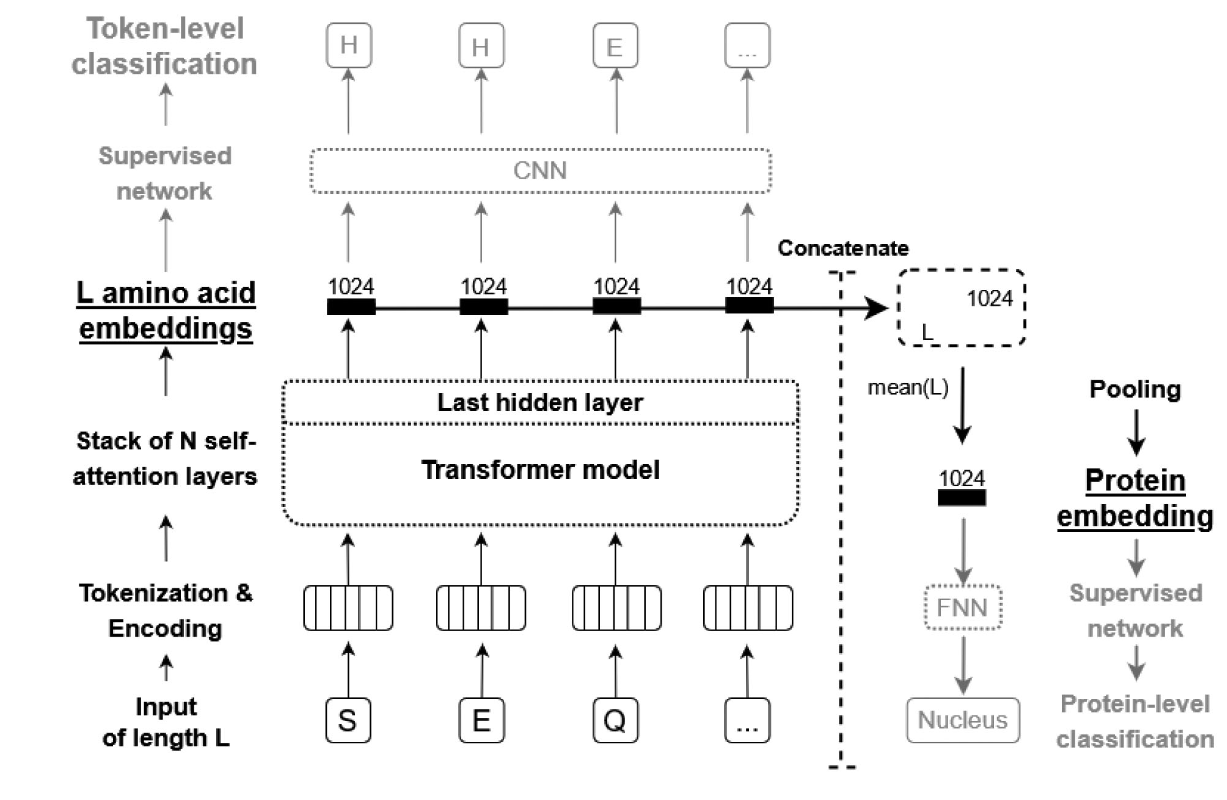

Image reference: Elnaggar, Ahmed, et al. "Prottrans: Toward understanding the language of life through self-supervised learning." IEEE transactions on pattern analysis and machine intelligence 44.10 (2021): 7112-7127.

### Loading ProtBERT

ProtBERT comes pretrained with models specifically trained on the Uniref100 and BFD datasets. These pretrained models are available for both Masked Language Modeling (MLM) and Sequence Classification tasks. This section covers how to load ProtBERT in different modes and provides details about the pretrained datasets available.

#### Pretrained Models:

1. **Uniref100 Model:**
   - **Description:** The Uniref100 model is pretrained on the Uniref100 [1] dataset.
   - **Usage:** Initialize ProtBERT with `model_path = 'Rostlab/prot_bert'` to load the Uniref100 pretrained model.

2. **BFD Model:**
   - **Description:** The BFD model is pretrained on the BFD(Big Fantastic Database) dataset [2][3].
   - **Usage:** Initialize ProtBERT with `model_path = 'Rostlab/prot_bert_bfd'` to load the BFD pretrained model.

#### Supported Modes:

1. **Masked Language Modeling (MLM):**
   - **Description:** ProtBERT learns to predict masked amino acids in protein sequences, facilitating a deeper understanding of amino acid relationships and sequence contexts.
   - **Usage:** Initialize ProtBERT with `task='mlm'` and specify either `model_path = 'Rostlab/prot_bert'` or `model_path = 'Rostlab/prot_bert_bfd'` for MLM tasks.

2. **Sequence Classification:**
   - **Description:** Enables classification tasks such as predicting membrane proteins, subcellular localization, or custom classifications using a user-defined classifier head.
   - **Usage:** Set `task='classification'` to utilize ProtBERT for sequence classification. Specify the `cls_name` parameter as 'LogReg', 'FFN', or 'custom' to use Logistic Regression, a simple 1-layer FFN, or a custom classifier network, respectively.
     - **Custom Task:** Set `cls_name='custom'` and provide a custom classifier head using the `classifier_net` argument. This allows users to apply a custom classifier head on top of the pretrained ProtBERT model.

References:

[1] Suzek, Baris E., et al. "UniRef: comprehensive and non-redundant UniProt reference clusters." Bioinformatics 23.10 (2007): 1282-1288.

[2] Steinegger, Martin, Milot Mirdita, and Johannes Söding. "Protein-level assembly increases protein sequence recovery from metagenomic samples manyfold." Nature methods 16.7 (2019): 603-606.

[3] Steinegger, Martin, and Johannes Söding. "Clustering huge protein sequence sets in linear time." Nature communications 9.1 (2018): 2542.

## Importing Model

In [16]:
finetune_model_dir = "finetuning/"

custom_network = nn.Sequential(nn.Linear(1024, 512),
                               nn.ReLU(), nn.Linear(512, 256),
                               nn.ReLU(), nn.Linear(256, 2)) # Network for custom classfication task

ProtBERTmodel_for_classification = ProtBERT(task='classification',
                                            model_path="Rostlab/prot_bert",
                                            n_tasks=1,
                                            cls_name="custom",
                                            classifier_net=custom_network,
                                            n_classes=2,
                                            model_dir=finetune_model_dir,
                                            batch_size=32,
                                            learning_rate=1e-5,
                                            log_frequency = 5) # ProtBERT model that can be used for fine-tuning for a downstream task



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Rostlab/prot_bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Fine-Tuning ProtBERT

Fine-tuning ProtBERT involves adapting the pretrained model to specific tasks or datasets, such as protein classification, subcellular localization prediction, or custom tasks. This process is crucial because it leverages the knowledge gained during pretraining on large datasets like Uniref100 or BFD. By fine-tuning, researchers can enhance ProtBERT's performance on targeted tasks without starting from scratch, thus accelerating model deployment and improving accuracy in biomedical applications.


In [17]:
# Freeze underlying ProtBERT and only train the classfier head
for param in ProtBERTmodel_for_classification.model.bert.parameters():
    param.requires_grad = False


In [18]:
all_losses = []
loss = ProtBERTmodel_for_classification.fit(deeploc_train_dataset, nb_epoch=1,all_losses = all_losses)

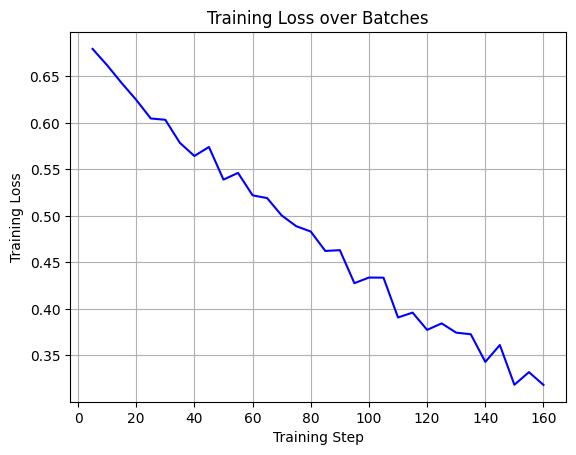

In [23]:
# Plot training loss
import matplotlib.pyplot as plt
batches = list(range(5, 5 * (len(all_losses) + 1), 5))
plt.plot(batches, all_losses, linestyle='-', color='b')
plt.title('Training Loss over Batches')
plt.xlabel('Training Step')
plt.ylabel('Training Loss')
plt.grid(True)
plt.show()

### Evaluation and Prediction

After training or fine-tuning, evaluate ProtBERT's performance using metrics like accuracy.


In [24]:
classification_metric = dc.metrics.Metric(dc.metrics.accuracy_score)
eval_score = ProtBERTmodel_for_classification.evaluate(deeploc_test_dataset, [classification_metric],n_classes=2)
eval_score

{'accuracy_score': 0.782}

The results demonstrate the fine-tuned model's accuracy in predicting soluble versus non-soluble proteins. Notably, training with the complete dataset yields an accuracy of around 0.87 [1].

[1] Elnaggar, Ahmed, et al. "ProtTrans: Toward understanding the language of life through self-supervised learning." IEEE Transactions on Pattern Analysis and Machine Intelligence 44.10 (2021): 7112-7127.

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!